## Fake data generator

The real data for this project is used from [The Research Productivity of New PhDs in Economics: The Surprisingly High Non-success of the Successful](https://www.aeaweb.org/articles?id=10.1257/jep.28.3.205). This data is available to anyone who wants it, but they must agree to the terms on the website.

As such, I am generating fake data so that someone looking at this repo in isolation can run the code. The data will have the same structure, but will be sampled from arbitrarily fitting distributions.

This fake data has the following properties:

*   AERPub score is sampled from $gamma(0.15, 0.3)$
*   School ranks were sampled uniformly for ranks 1-30, and then at 20x liklihood for 31+
*   Years are sampled uniformly from 1986 to 2000

A gamma distribution was chosen for of its tendency for the probability mass to be near 0 when scale is small. The parameters of $shape=0.15, scale=3$ were chose by eye.

In [223]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import scipy.stats as sci
import math

In [2]:
columns = ["PhD_ID", "Rank", "Year", "AERPub"]
min_year = 1986
max_year = 2000
num_grads_per_year = 900
num_entries = num_grads_per_year * (max_year - min_year)

# gamma_shape = 0.2
# gamma_scale = 3
base_sigma = 0.5

In [3]:
# Randomly assign IDs
phd_ids = np.arange(num_entries)
np.random.shuffle(phd_ids)

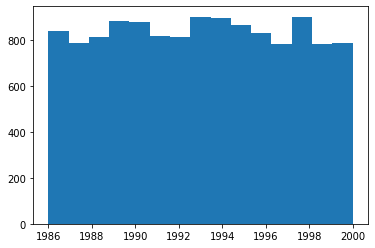

In [4]:
# Uniformly distribute the years
years = np.random.randint(min_year, max_year+1, num_entries)
plt.hist(years, bins = (max_year-min_year + 1));

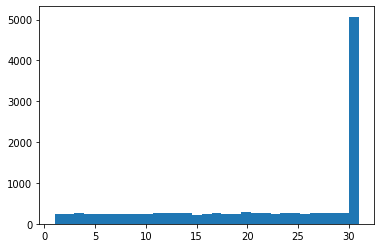

In [5]:
# Distribute the schools.
# Uniformly for the top 30 schools, and about 20x likelihood for the other schools.
school_dist = np.ones(31)
school_dist[30] = 20
school_dist = school_dist / school_dist.sum()
ranks = np.random.choice(np.arange(1,32), replace=True, size=[num_entries], p=school_dist)
plt.hist(ranks, bins=31);

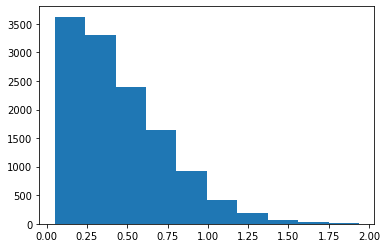

In [11]:
# Get AER ranks from gamma
# aers = np.random.gamma(gamma_shape, gamma_scale, num_entries)
aers_base = sci.halfnorm.rvs(loc=0.05, scale=base_sigma, size=num_entries)
plt.hist(aers_base);

In [13]:
mock_data = pd.DataFrame({"PhD_ID": phd_ids, "Rank": ranks, "Year": years, "AERPub":aers_base})

In [15]:
mock_data.to_csv("fake_data/mock_data.csv", index=False)

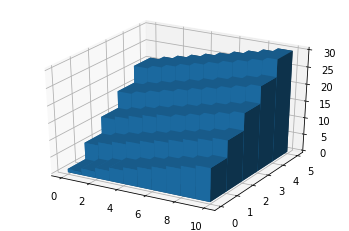

In [60]:
from mpl_toolkits.mplot3d import Axes3D
def plot_3d():
    #
    # Assuming you have "2D" dataset like the following that you need
    # to plot.
    #
    data_2d = [ [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                [6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
                [11, 12, 13, 14, 15, 16, 17, 18 , 19, 20],
                [16, 17, 18, 19, 20, 21, 22, 23, 24, 25],
                [21, 22, 23, 24, 25, 26, 27, 28, 29, 30] ]
    #
    # Convert it into an numpy array.
    #
    data_array = np.array(data_2d)
    #
    # Create a figure for plotting the data as a 3D histogram.
    #
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    #
    # Create an X-Y mesh of the same dimension as the 2D data. You can
    # think of this as the floor of the plot.
    #
    x_data, y_data = np.meshgrid( np.arange(data_array.shape[1]),
                                  np.arange(data_array.shape[0]) )
    #
    # Flatten out the arrays so that they may be passed to "ax.bar3d".
    # Basically, ax.bar3d expects three one-dimensional arrays:
    # x_data, y_data, z_data. The following call boils down to picking
    # one entry from each array and plotting a bar to from
    # (x_data[i], y_data[i], 0) to (x_data[i], y_data[i], z_data[i]).
    #
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = data_array.flatten()
    ax.bar3d( x_data,
              y_data,
              np.zeros(len(z_data)),
              1, 1, z_data )
    #
    # Finally, display the plot.
    #
    plt.show();

plot_3d()

In [156]:
def plot_schools(data, target_col, num_ranks=31):
    fig = plt.figure(figsize=(8,3))
    ax = fig.add_subplot(1, 2, 1, projection='3d')
    fig.set_dpi(200)
    
    lower_bound = 0
    upper_bound = math.ceil(data[target_col].max())
    bounds = (lower_bound, upper_bound)
    num_buckets=10
    
    grouped_data = data[["Rank", target_col]].groupby("Rank")
    hist_cols = grouped_data.agg(lambda row: get_hist_buckets(row, num_buckets, bounds))
    z_data = hist_cols.AERPub.explode().to_numpy()
    
#     z_data = np.array([np.arange(31), np.arange(1,11), np.arange(10), np.arange(2,12)])
    
    x_data, y_data = np.meshgrid( np.arange(1,num_ranks+1),
                                  np.arange(lower_bound, upper_bound+1))
    
    x_data = x_data.flatten()
    y_data = y_data.flatten()
    z_data = z_data.flatten()
    
    print("x:", x_data.shape)
    print("x:", x_data.shape)
    print("x:", x_data.shape)

    
    ax.bar3d(x=x_data,
             y=y_data,
             z=np.zeros(len(z_data)),
             dx=1,
             dy=1,
             dz=z_data)
    
def get_hist_buckets(data, num_buckets, bounds):
    factor = num_buckets / (bounds[1] - bounds[0])
    buckets = data.map(lambda x: int(x*factor//1))

    zerod_buckets = np.zeros(num_buckets)
    for index, value in buckets.value_counts().items():
        zerod_buckets[index] = value
        
    return zerod_buckets.tolist()

    
    
# plot_schools(mock_data,"AERPub")
# hist_buckets = get_hist_buckets(mock_data[mock_data.Rank == 1].AERPub, 20, (0,3))
# hist_buckets2 = get_hist_buckets(pd.Series(np.arange()))

In [87]:
grouped = mock_data[["Rank", "AERPub"]].groupby(by="Rank")

In [111]:
def agg_test(g, a):
#     print(type(g))
    print(a)
    return [g.mean(), g.max()]
    
def get_hist_buckets(data, num_buckets, bounds):
    factor = num_buckets / (bounds[1] - bounds[0])
    buckets = data.map(lambda x: int(x*factor//1))

    zerod_buckets = np.zeros(num_buckets)
    for index, value in buckets.value_counts().items():
        zerod_buckets[index] = value
        
    return zerod_buckets.tolist()

# grouped.agg(lambda x: agg_test(x, "foo"))
hist_by_rank = grouped.agg(lambda row: get_hist_buckets(row, 20, (0,3)))

# for rank, pubscore in grouped:
#     print(rank)
#     print(pubscore)

In [146]:
hist_by_rank.AERPub.to_numpy()

array([list([34.0, 55.0, 43.0, 34.0, 30.0, 14.0, 12.0, 9.0, 4.0, 1.0, 0.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([40.0, 57.0, 43.0, 30.0, 28.0, 12.0, 7.0, 5.0, 7.0, 4.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([40.0, 53.0, 52.0, 38.0, 40.0, 25.0, 9.0, 7.0, 2.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([44.0, 58.0, 47.0, 44.0, 25.0, 18.0, 10.0, 1.0, 4.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([44.0, 48.0, 40.0, 35.0, 31.0, 23.0, 8.0, 5.0, 5.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([38.0, 55.0, 46.0, 34.0, 25.0, 13.0, 14.0, 4.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([36.0, 74.0, 48.0, 25.0, 28.0, 17.0, 8.0, 7.0, 2.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([38.0, 55.0, 53.0, 36.0, 29.0, 20.0, 7.0, 7.0, 2.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]),
       list([41.0, 40.0, 43.0

[0.         0.13333333 0.26666667 0.4        0.53333333 0.66666667
 0.8        0.93333333 1.06666667 1.2        1.33333333 1.46666667
 1.6        1.73333333 1.86666667]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[0.12133891213389121 0.20502092050209206 0.18410041841004185
 0.1297071129707113 0.11297071129707113 0.08368200836820083
 0.0502092050209205 0.0502092050209205 0.029288702928870293
 0.016736401673640166 0.0 0.0041841004184100415 0.008368200836820083 0.0
 0.0041841004184100415]


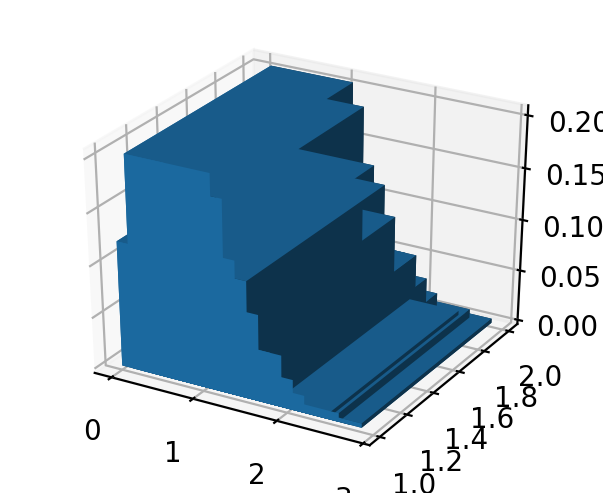

In [178]:
def get_hist_buckets(data, num_buckets, bounds):
    factor = num_buckets / (bounds[1] - bounds[0])
    buckets = data.map(lambda x: int(x*factor//1))

    zerod_buckets = np.zeros(num_buckets)
    for index, value in buckets.value_counts().items():
        zerod_buckets[index] = value
        
    zerod_buckets = zerod_buckets / zerod_buckets.sum()
        
    return zerod_buckets.tolist()

data = mock_data
target_col = "AERPub"
num_ranks = 1

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 2, 1, projection='3d')
fig.set_dpi(200)

lower_bound = 0
upper_bound = math.ceil(data[target_col].max())
bounds = (lower_bound, upper_bound)
num_buckets=15
step = (upper_bound - lower_bound) / num_buckets

grouped_data = data[data["Rank"] == 1][["Rank", target_col]].groupby("Rank")
hist_cols = grouped_data.agg(lambda row: get_hist_buckets(row, num_buckets, bounds))
z_data = hist_cols.AERPub.explode().to_numpy()

x_data, y_data = np.meshgrid(np.arange(lower_bound, upper_bound,  step=step),
                            np.arange(1,num_ranks+1))

x_data = x_data.flatten()
y_data = y_data.flatten()
z_data = z_data.flatten()

print(x_data)
print(y_data)
print(z_data)

ax.bar3d(x=x_data,
         y=y_data,
         z=np.zeros(len(z_data)),
         dx=1,
         dy=1,
         dz=z_data);
# ax.bar3d(x_data, y_data, z_data, dx=1, dy=1, dz=1)

In [179]:
# This might help
# https://stackoverflow.com/questions/8437788/how-to-correctly-generate-a-3d-histogram-using-numpy-or-matplotlib-built-in-func

# This one uses transparency
# https://stackoverflow.com/questions/23880138/display-a-3d-bar-graph-using-transparency-and-multiple-colors-in-matplotlib
np.histogram2d(x, y, bins=(20,20))


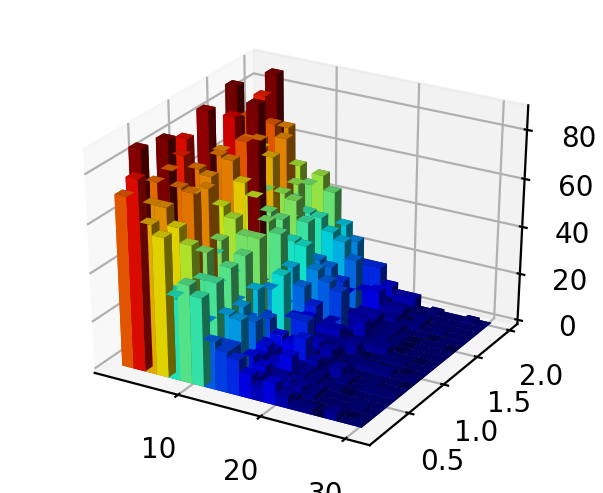

In [235]:
data = mock_data
target_col = "AERPub"
num_ranks = 1

fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(1, 2, 1, projection='3d')
fig.set_dpi(200)

# sorted_mock = mock_data[mock_data.Rank <= 30].sort_values(by="Rank")
# sorted_mock = mock_data[mock_data.Rank == 30].sort_values(by="Rank")
sorted_mock = mock_data[mock_data.Rank <= 30]
x = sorted_mock.Rank.values
y = sorted_mock.AERPub.values
hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))

xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

cmap = cm.get_cmap('jet') # Get desired colormap - you can change this!
max_height = np.max(dz)   # get range of colorbars so we can normalize
min_height = np.min(dz)
# scale each z to [0,1], and get their rgb values
rgba = [cmap((k-min_height)/max_height) for k in dz] 

# ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average')
ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=rgba, zsort='average');


In [205]:
sorted_mock = mock_data.sort_values(by="Rank")
x = sorted_mock.Rank.values
y = sorted_mock.AERPub.values

hist, xedges, yedges = np.histogram2d(x, y, bins=(20,20))
xpos, ypos = np.meshgrid(xedges[:-1]+xedges[1:], yedges[:-1]+yedges[1:])

xpos = xpos.flatten()/2.
ypos = ypos.flatten()/2.
zpos = np.zeros_like (xpos)

dx = xedges [1] - xedges [0]
dy = yedges [1] - yedges [0]
dz = hist.flatten()

array([0.05006806, 0.14445989, 0.23885172, 0.33324354, 0.42763537,
       0.5220272 , 0.61641903, 0.71081086, 0.80520268, 0.89959451,
       0.99398634, 1.08837817, 1.18277   , 1.27716182, 1.37155365,
       1.46594548, 1.56033731, 1.65472914, 1.74912096, 1.84351279,
       1.93790462])

In [ ]:
def get_cmap(dz, odd_bit):
    color = ""
    if (odd_bit):
        color = 'summer'
    else:
        color = "spring"
    color = "coolwarm"
    cmap = cm.get_cmap(color)
    max_height = np.max(dz)   # get range of colorbars so we can normalize
    min_height = np.min(dz)
    # scale each z to [0,1], and get their rgb values
    rgba = [cmap((zheight - min_height) / max_height) for zheight in dz] 
#     rgba
    return rgba


# data = mock_data
# target_col = "AERPub"
# num_ranks = 1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111, projection='3d')
fig.set_dpi(200)

num_bins = 8

lower_rank = 1
upper_rank = 31

for rank in range (lower_rank, upper_rank):
    single_school_d = mock_data[mock_data.Rank == rank]
    y_raw = single_school_d.AERPub
    
    hist, bin_edges = np.histogram(y_raw, bins=num_bins)
    y_back = bin_edges.flatten()[:-1]
    y = np.flip(y_back)
    x = np.ones(y.size) * rank
    z = np.zeros(y.size)

        
    # These are bar sizes.
    # Dx is the width on xdim
    # Dy is width on ydim
    # Dz is height on zdim
    dx = 1
    dy = bin_edges[1] - bin_edges[0] # step size
    dz = hist
    
    odd_bit = rank % 2
    cmap = get_cmap(dz, odd_bit)
#     print(cmap)
    ax.bar3d(x, y, z, dx, dy, dz, color = cmap, alpha=1)


xticks = [1,5,10,15,20,25,30]
yticks = [0, 0.5, 1, 1.5, 2]

# ax.spines["left"].set_visible(False)
# ax.spines["top"].set_visible(False)
# ax.spines["right"].set_visible(False)
# ax.spines["bottom"].set_visible(False)

xaxis = ax.get_xaxis()
yaxis = ax.get_yaxis()
zaxis = ax.get_zaxis()

# Make grey background transparent
xaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
yaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
zaxis.set_pane_color((1.0, 1.0, 1.0, 0.0))
# Make the grid lines transparent
xaxis._axinfo["grid"]['color'] =  (1,1,1,0)
yaxis._axinfo["grid"]['color'] =  (1,1,1,0)
zaxis._axinfo["grid"]['color'] =  (1,1,1,0)

# Hide spines
xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))
# ax.w_xaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
# ax.w_yaxis.line.set_color((1.0, 1.0, 1.0, 0.0)) 
# ax.w_zaxis.line.set_color((1.0, 1.0, 1.0, 0.0))

ax.set_title("Publishing distribution of students")
ax.set_xlabel("Schools by rank")
ax.set_ylabel("Number AER papers published")
ax.set_zlabel("Number of graduates")
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_yticklabels(np.flip(np.array(yticks)))
ax.set_zticks([]);
